In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preparation

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
# Paths to your data
train_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/training'
test_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/validation'

# Load ResNet50 pre-trained on ImageNet data, without the top fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(3, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Set the new learning rate
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model with the new learning rate
model.compile(optimizer=Adam(learning_rate=new_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare data using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_img_path, 
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_img_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Configure the ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.n // 32,
    callbacks=[checkpoint])


Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.
Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 13.2322 - accuracy: 0.3775
Epoch 1: val_accuracy improved from -inf to 0.55357, saving model to best_model.h5
43/43 [==============================] - 11s 160ms/step - loss: 13.2322 - accuracy: 0.3775 - val_loss: 11.3627 - val_accuracy: 0.5536
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 10.2008 - accuracy: 0.3982
Epoch 2: val_accuracy improved from 0.55357 to 0.57143, saving model to best_model.h5
43/43 [==============================] - 6s 132ms/step - loss: 10.2008 - accuracy: 0.3982 - val_loss: 8.7955 - val_accuracy: 0.5714
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 7.9371 - accuracy: 0.4256
Epoch 3: val_accuracy did not improve from 0.57143
43/43 [==============================] - 5s 124ms/step - loss: 7.9371 - accuracy: 0.4256 - val_loss: 6.8665 - val_accuracy: 0.5536
Epoch 4/50
43/43

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import efficientnet.tfkeras as efn

train_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/training'
test_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/validation'

base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Increased dropout rate
predictions = Dense(3, activation='softmax')(x)

model_EfficientNet = Model(inputs=base_model.input, outputs=predictions)

new_learning_rate = 0.0001
model_EfficientNet.compile(optimizer=Adam(learning_rate=new_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_img_path, 
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_img_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint('best_efficientnet_model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

# EarlyStopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_eff = model_EfficientNet.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.n // 32,
    callbacks=[checkpoint, early_stopping])  # Added early stopping here


Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.
Epoch 1/50


2023-12-22 20:54:58.067564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 [==============================] - ETA: 0s - loss: 0.9832 - accuracy: 0.4863
Epoch 1: val_loss improved from inf to 0.77298, saving model to best_efficientnet_model.h5
43/43 [==============================] - 24s 417ms/step - loss: 0.9832 - accuracy: 0.4863 - val_loss: 0.7730 - val_accuracy: 0.6964
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.8684 - accuracy: 0.5774
Epoch 2: val_loss improved from 0.77298 to 0.71875, saving model to best_efficientnet_model.h5
43/43 [==============================] - 17s 385ms/step - loss: 0.8684 - accuracy: 0.5774 - val_loss: 0.7188 - val_accuracy: 0.7054
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.8353 - accuracy: 0.6070
Epoch 3: val_loss did not improve from 0.71875
43/43 [==============================] - 16s 371ms/step - loss: 0.8353 - accuracy: 0.6070 - val_loss: 0.7275 - val_accuracy: 0.6786
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss: 0.7869 - accuracy: 0.6440
Epoch 

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

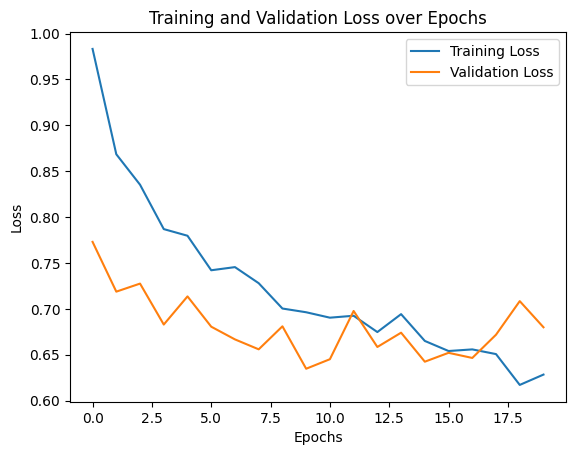

In [19]:
all_train_loss_histories = [history_eff.history['loss']]
all_val_loss_histories = [history_eff.history['val_loss']]

plt.plot(history_eff.history['loss'], label='Training Loss')
plt.plot(history_eff.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

Text(0.5, 1.0, 'Training and Validation accuracy over Epochs')

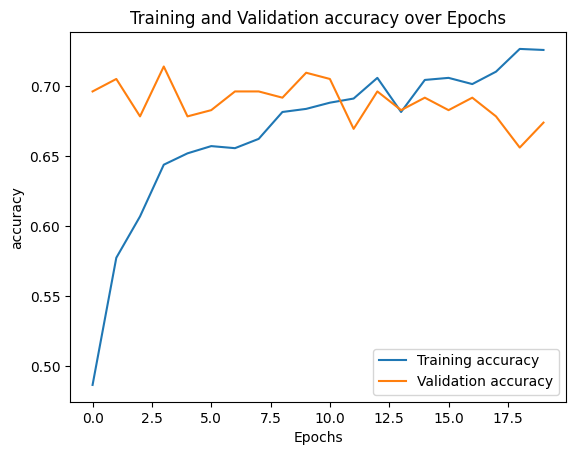

In [23]:
all_train_loss_histories = [history_eff.history['accuracy']]
all_val_loss_histories = [history_eff.history['val_accuracy']]

plt.plot(history_eff.history['accuracy'], label='Training accuracy')
plt.plot(history_eff.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation accuracy over Epochs')

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

train_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/training'
test_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/validation'

# Load InceptionV3 pre-trained on ImageNet data, without the top fully connected layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Added dropout
predictions = Dense(3, activation='softmax')(x)

model_InceptionV3 = Model(inputs=base_model.input, outputs=predictions)

new_learning_rate = 0.0001
model_InceptionV3.compile(optimizer=Adam(learning_rate=new_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_img_path, 
    target_size=(299, 299), 
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_img_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint('best_inceptionv3_model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

# EarlyStopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_inceptionv3 = model_InceptionV3.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.n // 32,
    callbacks=[checkpoint, early_stopping])  # Added early stopping here


Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.
Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.1210 - accuracy: 0.4204
Epoch 1: val_loss improved from inf to 0.88640, saving model to best_inceptionv3_model.h5
43/43 [==============================] - 36s 714ms/step - loss: 1.1210 - accuracy: 0.4204 - val_loss: 0.8864 - val_accuracy: 0.6250
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.9723 - accuracy: 0.5455
Epoch 2: val_loss improved from 0.88640 to 0.78660, saving model to best_inceptionv3_model.h5
43/43 [==============================] - 30s 695ms/step - loss: 0.9723 - accuracy: 0.5455 - val_loss: 0.7866 - val_accuracy: 0.7054
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.9002 - accuracy: 0.5581
Epoch 3: val_loss improved from 0.78660 to 0.75335, saving model to best_inceptionv3_model.h5
43/43 [==============================] - 29s 684ms/step - loss: 0.9002 - accuracy: 0.5581 - v

Text(0.5, 1.0, 'Training and Validation Loss over Epochs for the inceptionv3')

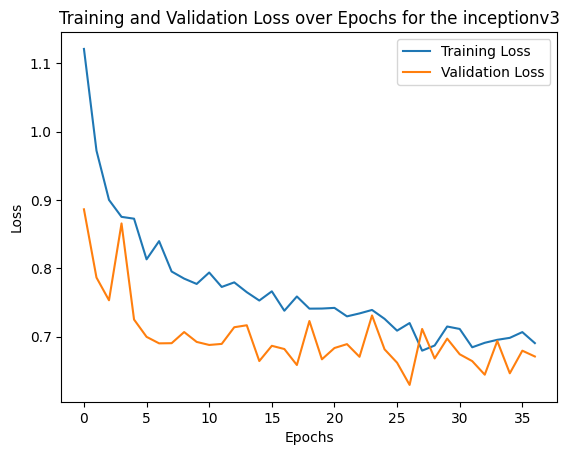

In [22]:
all_train_loss_histories = [history_inceptionv3.history['loss']]
all_val_loss_histories = [history_inceptionv3.history['val_loss']]

plt.plot(history_inceptionv3.history['loss'], label='Training Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs forhistory_inceptionv3')

Text(0.5, 1.0, 'Training and Validation accuracy over Epochs history_inceptionv3')

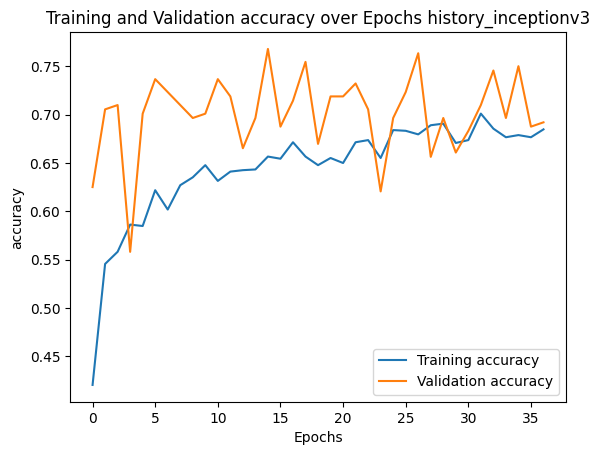

In [24]:
all_train_loss_histories = [history_inceptionv3.history['accuracy']]
all_val_loss_histories = [history_inceptionv3.history['val_accuracy']]

plt.plot(history_inceptionv3.history['accuracy'], label='Training accuracy')
plt.plot(history_inceptionv3.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation accuracy over Epochs history_inceptionv3')

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

train_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/training'
test_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/validation'

# Load VGG16 pre-trained on ImageNet data, without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Added dropout
predictions = Dense(3, activation='softmax')(x)

model_VGG16 = Model(inputs=base_model.input, outputs=predictions)

new_learning_rate = 0.0001
model_VGG16.compile(optimizer=Adam(learning_rate=new_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_img_path, 
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_img_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint('best_vgg16_model.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

# EarlyStopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_vgg16 = model_VGG16.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.n // 32,
    callbacks=[checkpoint, early_stopping])  # Added early stopping here


58889256/58889256 [==============================] - 0s 0us/step
Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.
Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.1158 - accuracy: 0.3805
Epoch 1: val_loss improved from inf to 0.99282, saving model to best_vgg16_model.h5
43/43 [==============================] - 23s 397ms/step - loss: 1.1158 - accuracy: 0.3805 - val_loss: 0.9928 - val_accuracy: 0.5804
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 1.0574 - accuracy: 0.4493
Epoch 2: val_loss improved from 0.99282 to 0.90540, saving model to best_vgg16_model.h5
43/43 [==============================] - 17s 399ms/step - loss: 1.0574 - accuracy: 0.4493 - val_loss: 0.9054 - val_accuracy: 0.6562
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 1.0089 - accuracy: 0.4759
Epoch 3: val_loss improved from 0.90540 to 0.87226, saving model to best_vgg16_model.h5
43/43 [==============================] - 17s 3

Text(0.5, 1.0, 'Training and Validation Loss over Epochs forhistory_vgg16')

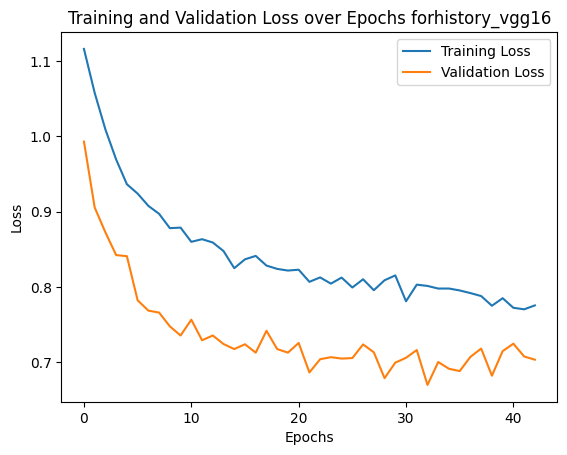

In [27]:
all_train_loss_histories = [history_vgg16.history['loss']]
all_val_loss_histories = [history_vgg16.history['val_loss']]

plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs forhistory_vgg16')

Text(0.5, 1.0, 'Training and Validation accuracy over Epochs history_vgg16')

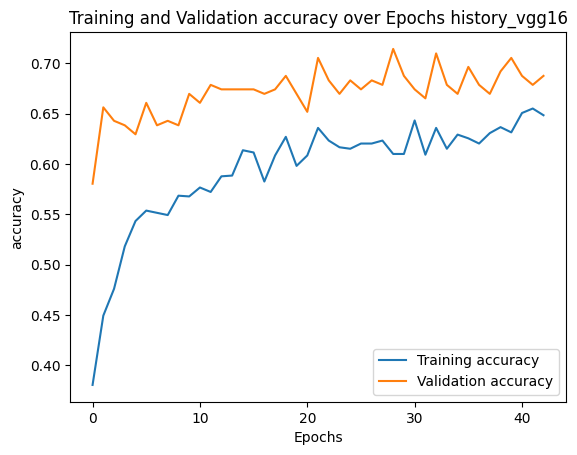

In [28]:
all_train_loss_histories = [history_vgg16.history['accuracy']]
all_val_loss_histories = [history_vgg16.history['val_accuracy']]

plt.plot(history_vgg16.history['accuracy'], label='Training accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation accuracy over Epochs history_vgg16')

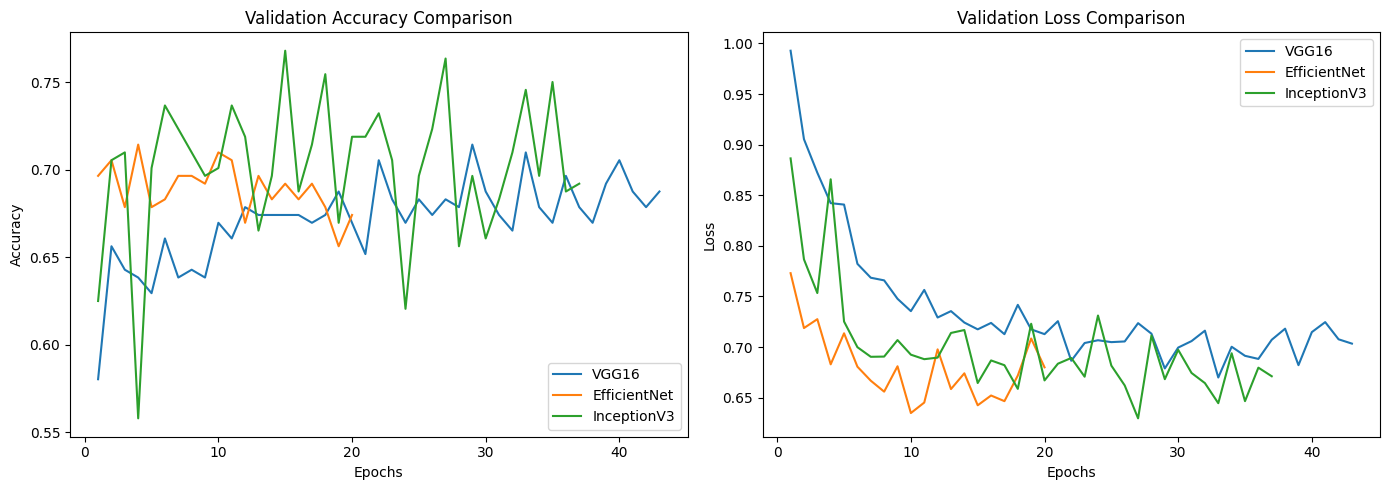

In [31]:
import matplotlib.pyplot as plt

# Get the number of epochs trained for each model
epochs_vgg16 = range(1, len(history_vgg16.history['val_accuracy']) + 1)
epochs_efficientnet = range(1, len(history_eff.history['val_accuracy']) + 1)
epochs_inceptionv3 = range(1, len(history_inceptionv3.history['val_accuracy']) + 1)

# Plot validation accuracy for each model
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_vgg16, history_vgg16.history['val_accuracy'], label='VGG16')
plt.plot(epochs_efficientnet, history_eff.history['val_accuracy'], label='EfficientNet')
plt.plot(epochs_inceptionv3, history_inceptionv3.history['val_accuracy'], label='InceptionV3')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss for each model
plt.subplot(1, 2, 2)
plt.plot(epochs_vgg16, history_vgg16.history['val_loss'], label='VGG16')
plt.plot(epochs_efficientnet, history_eff.history['val_loss'], label='EfficientNet')
plt.plot(epochs_inceptionv3, history_inceptionv3.history['val_loss'], label='InceptionV3')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

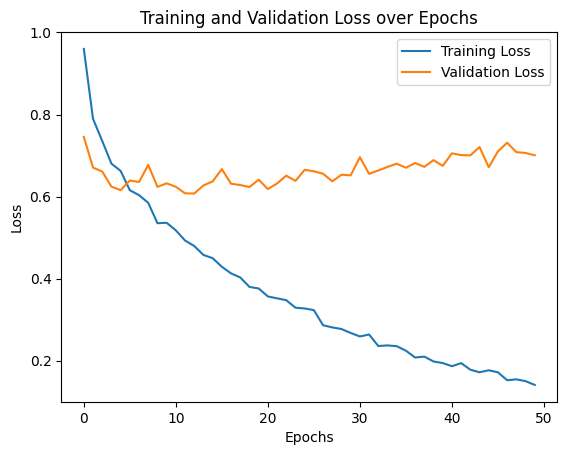

In [16]:
all_train_loss_histories = [history_eff.history['loss']]
all_val_loss_histories = [history_eff.history['val_loss']]

plt.plot(history_eff.history['loss'], label='Training Loss')
plt.plot(history_eff.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

Text(0.5, 1.0, 'Training and Validation Loss over Epochs')

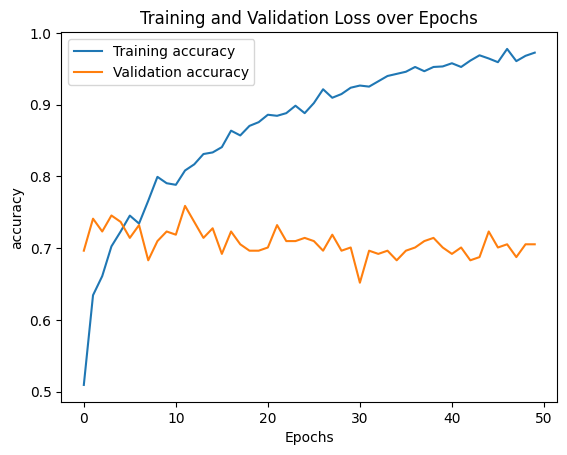

In [17]:
all_train_loss_histories = [history_eff.history['accuracy']]
all_val_loss_histories = [history_eff.history['val_accuracy']]

plt.plot(history_eff.history['accuracy'], label='Training accuracy')
plt.plot(history_eff.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

In [ ]:
train_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/training'
test_img_path = '/kaggle/input/car-damage-severity-dataset/data3a/validation'

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        validation_split=0.20,) 

# Use flow_from_directory for the training dataset
train_ds = train_data_gen.flow_from_directory(
    train_img_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='training', 
    seed=123,
    shuffle=True  
)
valid_ds = train_data_gen.flow_from_directory(
    train_img_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation', 
    seed=123,
    shuffle=True  
)

In [ ]:
test_data_gen = ImageDataGenerator(rescale=1./255,)  # You may adjust other parameters as needed

# Use flow_from_directory for the test dataset
test_ds = test_data_gen.flow_from_directory(
    test_img_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Assuming label_mode='int' in your original code
    shuffle=False  # Set to True if you want to shuffle the data
)

In [ ]:
cl=test_ds.class_indices
print(cl)

In [ ]:
def plot_images_from_dataset(dataset, num_images=9):
    # Fetch a batch of images and labels from the dataset
    images, labels = next(iter(dataset))

    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        # Map the label index back to the original class name
        label_index = labels[i].argmax()  # Assumes one-hot encoding
        class_name = next(key for key, value in cl.items() if value == label_index)
        
        plt.title(f"Class: {class_name}")
        plt.axis("off")
    plt.show()


# Assuming test_ds is your dataset
plot_images_from_dataset(test_ds)


# First Model : Resnet

In [ ]:
# Use ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model by adding custom top layers for multi-class classification
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))


for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


In [ ]:
epochs=50

# Train the model
history_resnet = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    verbose=1,
)

# Save training and validation histories for later analysis
all_train_histories = [history_resnet.history['accuracy']]
all_val_histories = [history_resnet.history['val_accuracy']]


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Get predictions for the test set
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)



In [ ]:
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

In [ ]:
all_train_loss_histories = [history_resnet.history['loss']]
all_val_loss_histories = [history_resnet.history['val_loss']]

plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
true_labels = test_ds.classes
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()


In [ ]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]
num_images_to_display = 6
for i in range(min(num_images_to_display, len(misclassified_indices))):
    index = misclassified_indices[i]
    
    # Load and display the misclassified image
    image = plt.imread(valid_ds.filepaths[index])
    plt.imshow(image)
    
    # Display true and predicted labels
    true_label = valid_ds.classes[index]
    predicted_label = predicted_labels[index]
    
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()

# Second Model: 4D Model

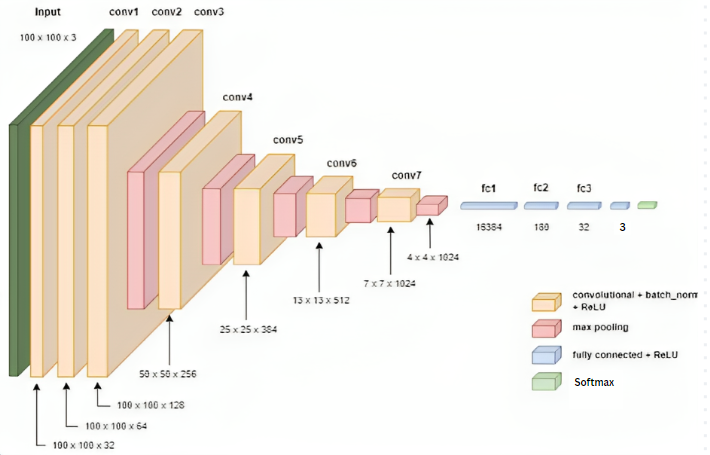

In [ ]:
model_4d = models.Sequential()

model_4d.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
model_4d.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4d.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))
model_4d.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))
model_4d.add(layers.Conv2D(384, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))
model_4d.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))
model_4d.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model_4d.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from Conv2D layers
model_4d.add(layers.Flatten())

# Add fully connected layers with specified parameters and regularization
model_4d.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4d.add(layers.Dropout(0.5))
model_4d.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4d.add(layers.Dropout(0.5))
model_4d.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4d.add(layers.Dense(3, activation='softmax'))


In [ ]:
model_4d.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'AUC'])

model_4d.summary()

In [ ]:
epochs=50

# Train the model
history = model_4d.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,  # Use a part of train_ds as validation data
    verbose=1,
)

# Save training and validation histories for later analysis
all_train_histories = [history.history['accuracy']]
all_val_histories = [history.history['val_accuracy']]


In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_loss, test_accuracy = model_4d.evaluate(test_ds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

In [ ]:
# Confusion matrix
true_labels = test_ds.classes
predictions = model_4d.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [ ]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]
num_images_to_display = 6
for i in range(min(num_images_to_display, len(misclassified_indices))):
    index = misclassified_indices[i]
    
    # Load and display the misclassified image
    image = plt.imread(valid_ds.filepaths[index])
    plt.imshow(image)
    
    # Display true and predicted labels
    true_label = valid_ds.classes[index]
    predicted_label = predicted_labels[index]
    
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()

# Third Model : EfficientNet

In [ ]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow_addons.metrics import F1Score

img_size = (224, 224)
lr = 0.001
class_count = 3

img_shape = (img_size[0], img_size[1], 3)

base_model = DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
base_model.trainable = True
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model_eff = Model(inputs=base_model.input, outputs=output)
model_eff.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', 
              metrics=['accuracy','AUC'])





In [ ]:
epochs=50

# Train the model
history_eff = model_eff.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,  
    verbose=1,
)

# Save training and validation histories for later analysis
all_train_histories = [history_eff.history['accuracy']]
all_val_histories = [history_eff.history['val_accuracy']]

In [ ]:
model_eff.save('model_eff.h5')

In [ ]:
plt.plot(history_eff.history['accuracy'], label='Training Accuracy')
plt.plot(history_eff.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

# Testing code
test_accuracy = model_eff.evaluate(test_ds)


In [ ]:
# Confusion matrix
true_labels = test_ds.classes
predictions = model_eff.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_labels))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [ ]:
misclassified_indices = np.where(predicted_labels != true_labels)[0]
num_images_to_display = 4
for i in range(min(num_images_to_display, len(misclassified_indices))):
    index = misclassified_indices[i]
    
    # Load and display the misclassified image
    image = plt.imread(valid_ds.filepaths[index])
    plt.imshow(image)
    
    # Display true and predicted labels
    true_label = valid_ds.classes[index]
    predicted_label = predicted_labels[index]
    
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()

# Comparison among the three models used.

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have your test data generator named test_ds
# and class_labels is a list of your class labels

# Evaluate model
model_eval = model.evaluate(test_ds)
y_pred = model.predict(test_ds)
y_true = test_ds.classes
print("Model Metrics:")
print(model_eval)

# Generate classification report
class_report_model = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=cl)
print("Classification Report - Model:")
print(class_report_model)

# Repeat for model_4d
model_4d_eval = model_4d.evaluate(test_ds)
y_pred_4d = model_4d.predict(test_ds)
print("\nModel_4d Metrics:")
print(model_4d_eval)

class_report_model_4d = classification_report(y_true, np.argmax(y_pred_4d, axis=1), target_names=cl)
print("Classification Report - Model_4d:")
print(class_report_model_4d)

# Repeat for model_eff
model_eff_eval = model_eff.evaluate(test_ds)
y_pred_eff = model_eff.predict(test_ds)
print("\nModel_eff Metrics:")
print(model_eff_eval)

class_report_model_eff = classification_report(y_true, np.argmax(y_pred_eff, axis=1), target_names=cl)
print("Classification Report - Model_eff:")
print(class_report_model_eff)


In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Assuming you have your test data generator named test_ds
# and class_labels is a list of your class labels

# Function to calculate precision, recall, f1-score, and accuracy
def calculate_metrics(model, test_ds, class_labels):
    y_pred = model.predict(test_ds)
    y_true = test_ds.classes
    accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1), average='weighted')
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    return metrics

# Calculate metrics for each model
metrics_model = calculate_metrics(model, test_ds, cl)
metrics_model_4d = calculate_metrics(model_4d, test_ds, cl)
metrics_model_eff = calculate_metrics(model_eff, test_ds, cl)

# Create a DataFrame
df = pd.DataFrame([metrics_model, metrics_model_4d, metrics_model_eff], index=['Model', 'Model_4d', 'Model_eff'])

# Display the DataFrame
print(df)
